Link for the dataset and details about it: https://www.kaggle.com/datasets/shree1992/data-integration-and-reshaping/data?select=data_s2.csv

In [1]:
pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=b40f24046a949a2efd8be5d69021f46220c8d052bbc096f8ecc51897972b16e6
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
#initislizing the Spark session
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Data Integration').getOrCreate()


In [3]:
df = spark.read.csv("Normalised.csv", header=True, inferSchema=True)
df.show()

+-------------------+-------+--------+---------+-----------+--------+------+----------+----+---------+----------+-------------+--------+------------+--------------------+----------------+-----+--------+-------+----------------+-------------+-------------+-------------+
|               date|  price|bedrooms|bathrooms|sqft_living|sqft_lot|floors|waterfront|view|condition|sqft_above|sqft_basement|yr_built|yr_renovated|              street|            city|state|statezip|country|         Pscaled|          lmr|      sqr_pow|    log_trans|
+-------------------+-------+--------+---------+-----------+--------+------+----------+----+---------+----------+-------------+--------+------------+--------------------+----------------+-----+--------+-------+----------------+-------------+-------------+-------------+
|2014-05-02 00:00:00| 313000|       3|      1.5|       1340|    7912|   1.5|         0|   0|      3.0|      1340|            0|    1955|        2005|18810 Densmore Ave N|       Shoreline|   

The code below shows the word count for each city, or the number of times a certain city has appeared in the dataset.

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, trim #details for graph appearance


# Initialize the Spark Session
spark = SparkSession.builder.appName("CityCount").getOrCreate()

# Read the CSV File
df = spark.read.csv("Normalised.csv", header=True, inferSchema=True)

# Select and preprocess the "city" Column
city_df = df.select(lower(trim(col("city"))).alias("city"))

# Perform the City Count
city_count_df = city_df.groupBy("city").count().orderBy("count", ascending=False)
city_count_df.show(20, truncate=False)#printing top 20 cities

+-------------+-----+
|city         |count|
+-------------+-----+
|seattle      |1694 |
|bellevue     |313  |
|renton       |310  |
|redmond      |249  |
|kirkland     |213  |
|issaquah     |200  |
|kent         |199  |
|sammamish    |191  |
|auburn       |181  |
|federal way  |159  |
|shoreline    |131  |
|woodinville  |117  |
|maple valley |100  |
|mercer island|90   |
|burien       |79   |
|snoqualmie   |74   |
|kenmore      |72   |
|des moines   |61   |
|north bend   |51   |
|covington    |49   |
+-------------+-----+
only showing top 20 rows



In [19]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import col
# List of features to be used in the model
feature_cols = ['price', 'yr_built', 'bedrooms']

# Vectorize features
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df = assembler.transform(df)

# Check vectorization output
df.select("features").show(5, truncate=False)

# Normalize features
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=False)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Verify scaling
df.select("features", "scaledFeatures").show(5, truncate=False)

+----------------------+
|features              |
+----------------------+
|[313000.0,1955.0,3.0] |
|[2384000.0,1921.0,5.0]|
|[342000.0,1966.0,3.0] |
|[420000.0,1963.0,3.0] |
|[550000.0,1976.0,4.0] |
+----------------------+
only showing top 5 rows

+----------------------+--------------------------------------------------------+
|features              |scaledFeatures                                          |
+----------------------+--------------------------------------------------------+
|[313000.0,1955.0,3.0] |[0.834426821519005,65.91669268225854,3.296786008363748] |
|[2384000.0,1921.0,5.0]|[6.3555065255632845,64.77031541821927,5.494643347272913]|
|[342000.0,1966.0,3.0] |[0.9117379327779543,66.28757944415361,3.296786008363748]|
|[420000.0,1963.0,3.0] |[1.1196781630606458,66.18642850909131,3.296786008363748]|
|[550000.0,1976.0,4.0] |[1.466245213531798,66.62474922769456,4.39571467781833]  |
+----------------------+--------------------------------------------------------+
only showing

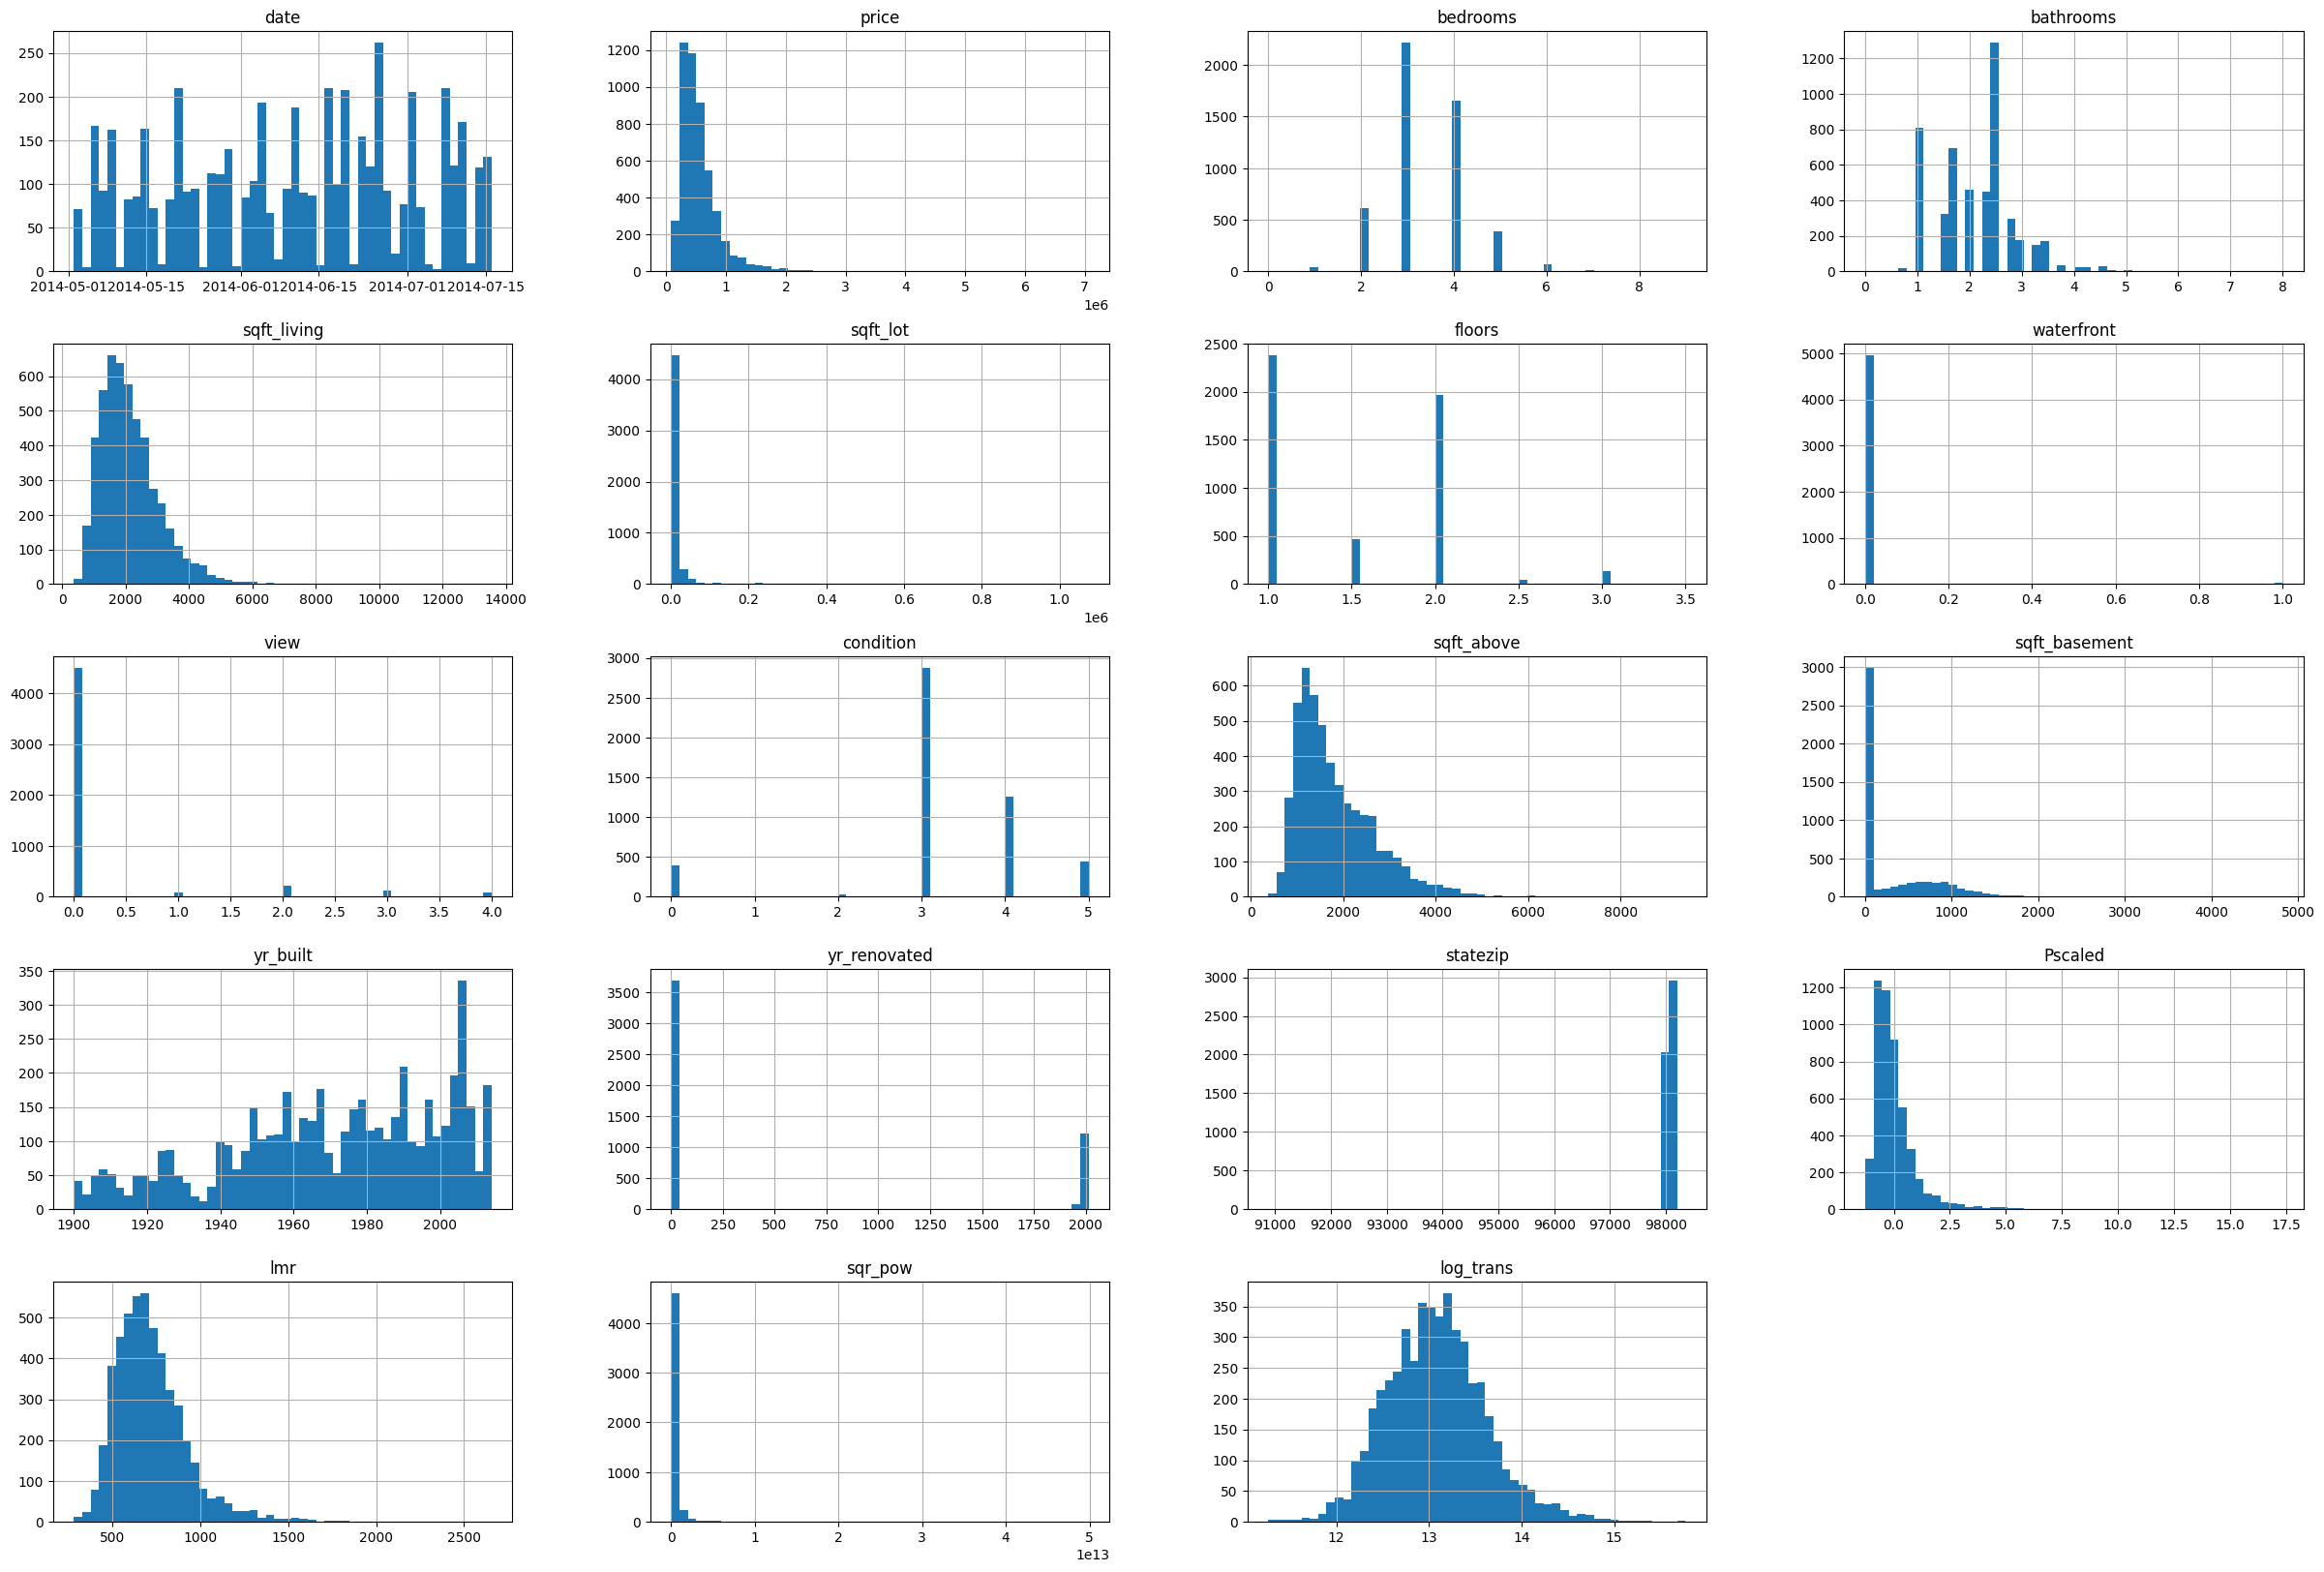

In [12]:
# Visualization
import pandas as pd
import matplotlib.pyplot as plt

pandas_df = df.toPandas()
pandas_df.hist(bins=50, figsize=(30, 20))
plt.show()


## **Data Reconciliation**


using data reconciliation to compare between the two datasets and examine their alignment.

In [22]:
# Initialize Spark session
spark = SparkSession.builder.appName("DataReconciliation").getOrCreate()

# Loading in the data as dfs
df1 = spark.read.csv('Normalised.csv', header=True, inferSchema=True)
df2 = spark.read.csv('data_s2.csv', header=True, inferSchema=True)

# Show the schema of each df
df1_schema = df1.printSchema()
df1_preview = df1.show(5)#showing the first 5

df2_schema = df2.printSchema()
df2_preview = df2.show(5)

df1_schema, df1_preview, df2_schema, df2_preview


root
 |-- date: timestamp (nullable = true)
 |-- price: integer (nullable = true)
 |-- bedrooms: integer (nullable = true)
 |-- bathrooms: double (nullable = true)
 |-- sqft_living: integer (nullable = true)
 |-- sqft_lot: integer (nullable = true)
 |-- floors: double (nullable = true)
 |-- waterfront: integer (nullable = true)
 |-- view: integer (nullable = true)
 |-- condition: double (nullable = true)
 |-- sqft_above: integer (nullable = true)
 |-- sqft_basement: integer (nullable = true)
 |-- yr_built: integer (nullable = true)
 |-- yr_renovated: integer (nullable = true)
 |-- street: string (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- statezip: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- Pscaled: double (nullable = true)
 |-- lmr: double (nullable = true)
 |-- sqr_pow: double (nullable = true)
 |-- log_trans: double (nullable = true)

+-------------------+-------+--------+---------+-----------+--------+--

(None, None, None, None)

In [26]:
#Merging the files

spark = SparkSession.builder.appName("MergeCSVs").getOrCreate()

# Select and rename columns to match schemas before union
df1 = df1.selectExpr("bedrooms as Bed_rooms", "bathrooms as Bath_rooms", "price as Price", "date as Date")
df2 = df2.selectExpr("bedrooms as Bed_rooms", "bathrooms as Bath_rooms", "price as Price", "date as Date")

merged_df = df1.union(df2)


# Save the merged DataFrame
merged_df.write.csv('merged_csv_file.csv', header=True)



AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `bedrooms` cannot be resolved. Did you mean one of the following? [`Bed_rooms`, `Bath_rooms`, `Price`, `Date`].; line 1 pos 0;
'Project ['bedrooms AS Bed_rooms#1134, 'bathrooms AS Bath_rooms#1135, price#1095 AS Price#1136, date#1096 AS Date#1137]
+- Project [bedrooms#808 AS Bed_rooms#1093, bathrooms#809 AS Bath_rooms#1094, price#807 AS Price#1095, date#806 AS Date#1096]
   +- Relation [date#806,price#807,bedrooms#808,bathrooms#809,sqft_living#810,sqft_lot#811,floors#812,waterfront#813,view#814,condition#815,sqft_above#816,sqft_basement#817,yr_built#818,yr_renovated#819,street#820,city#821,state#822,statezip#823,country#824,Pscaled#825,lmr#826,sqr_pow#827,log_trans#828] csv


The error was raised because I ran the cell again after the analysis was done.

In [28]:
merged_df.show()

+---------+----------+-------+-------------------+
|Bed_rooms|Bath_rooms|  Price|               Date|
+---------+----------+-------+-------------------+
|        3|       1.5| 313000|2014-05-02 00:00:00|
|        5|       2.5|2384000|2014-05-02 00:00:00|
|        3|       2.0| 342000|2014-05-02 00:00:00|
|        3|      2.25| 420000|2014-05-02 00:00:00|
|        4|       2.5| 550000|2014-05-02 00:00:00|
|        2|       1.0| 490000|2014-05-02 00:00:00|
|        2|       2.0| 335000|2014-05-02 00:00:00|
|        4|       2.5| 482000|2014-05-02 00:00:00|
|        3|       2.5| 452500|2014-05-02 00:00:00|
|        4|       2.0| 640000|2014-05-02 00:00:00|
|        3|      1.75| 463000|2014-05-02 00:00:00|
|        4|       2.5|1400000|2014-05-02 00:00:00|
|        3|      1.75| 588500|2014-05-02 00:00:00|
|        3|       1.0| 365000|2014-05-02 00:00:00|
|        5|      2.75|1200000|2014-05-02 00:00:00|
|        3|       1.5| 242500|2014-05-02 00:00:00|
|        3|       1.5| 419000|2